<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork1047-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


#  **Softmax Regression, One-vs-All and One-vs-One for Multi-class Classification**


Estimated time needed: **1** hour


 In this lab, we will study how to convert a linear classifier into a multi-class classifier, including multinomial logistic regression or softmax regression, One vs. All (One-vs-Rest) and One vs. One.


## **Objectives**


After completing this lab you will be able to:


*   Understand and apply some theory behind:
    *  Softmax regression
    *  One vs. All (One-vs-Rest)
    * One vs. One


## **Introduction**


In Multi-class classification, we classify data into multiple class labels. Unlike classification trees and k-nearest neighbor, the concept of multi-class classification for linear classifiers is not as straightforward. We can convert logistic regression to multi-class classification using multinomial logistic regression or softmax regression; this is a generalization of logistic regression, this will not work for support vector machines. One vs. All (One-vs-Rest) and One vs. One are two other multi-class classification techniques can convert any two-class classifier into a multi-class classifier.


***


## **Install and Import the required libraries**


For this lab, we are going to be using several Python libraries such as scit-learn, numpy, and matplotlib  for visualizations. Some of these libraries might be installed in your lab environment, and others may need to be installed by you by removing the hash signs. The cells below will install these libraries when executed.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# standard datasets
from sklearn import datasets
# support vector machine
from sklearn.svm import SVC
# logistic regression
from sklearn.linear_model import LogisticRegression
# model evaluation metrics
from sklearn.metrics import accuracy_score

## Utility Function


This function plots a different decision boundary. 


In [2]:
# set the colors used for plotting
plot_colors = "ryb"
# define the resolution of the mesh grid
plot_step = 0.02

def decision_boundary(X, y, model):
    # calculate the minimum and maximum values for the features and add a margin
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # create a mesh grid for the range of x and y values
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    # predict the model output for each point on the grid
    # concatenation along the second axis
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # create a contour plot using the predictions
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    # plot the training points
    for i, color in zip(np.unique(y), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

    plt.suptitle("Decision surface of a model")
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    plt.axis("tight")
    
    # add axis labels (assuming iris dataset here)
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    
    # show the plot
    plt.show()

This function will plot the probability of belonging to each class; each column is the probability of belonging to a class and the row number is the sample number.


In [3]:
def plot_probability_array(X, probability_array):
    # initialize plot_array with zeros; it has 3 blocks, each 10 columns wide
    plot_array = np.zeros((X.shape[0], 3 * 10))
    
    # loop through each class and fill the plot_array
    for class_idx in range(3):  # there are 3 classes
        col_start = class_idx * 10  # start column for the current class block
        col_end = col_start + 10    # end column for the current class block
        
        # fill the block with the repeated class probabilities
        # when you index a 2D array, you typically get a 1D array back,
        # np.newaxis is used to convert this 1D array back into a 2D array
        plot_array[:, col_start:col_end] = np.tile(probability_array[:, class_idx, np.newaxis], (1, 10))
    
    # the probabilities can be visualized as a heatmap where each cell's
    # color intensity represents the probability value
    plt.imshow(plot_array, aspect='auto')
    # remove x-tick
    plt.xticks([])
    plt.ylabel("Samples")
    plt.xlabel("Probability of 3 Classes")
    # a color bar is added to the side of the plot to indicate the scale of probabilities
    plt.colorbar()
    plt.show()

In ths lab we will use the  iris dataset,  it consists of three different types of irises’ (Setosa y=0, Versicolour y=1, and Virginica y=2), petal and sepal length, stored in a 150x4 numpy.ndarray.

The rows being the samples and the columns: Sepal Length, Sepal Width, Petal Length and Petal Width.

The following plot uses the second two features:


In [4]:
# creates a list 'pair' used as indices
pair=[1, 3]
# load the iris dataset
iris = datasets.load_iris()
# choose [1, 3] columns of X
X = iris.data[:, pair]
# assign target/label to y
y = iris.target
np.unique(y)

array([0, 1, 2])

Text(0, 0.5, 'petal width')

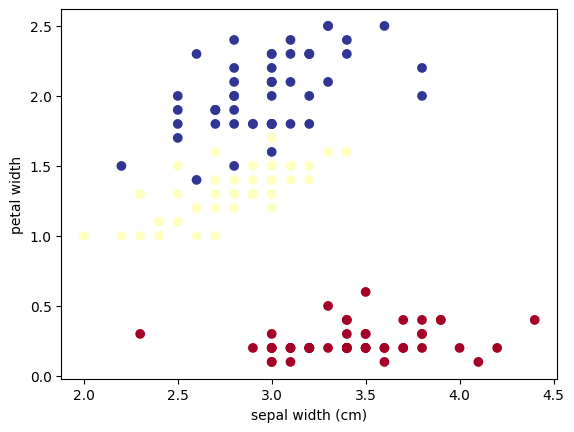

In [5]:
# 0 column represents sepal width and 1 column represents petal width
# the points are colored based on each sample label
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("sepal width (cm)")
plt.ylabel("petal width")

## **Softmax Regression**  


SoftMax regression is similar to logistic regression, and the softmax function converts the actual distances, that is, dot products of $x$ with each of the parameters $\theta_i$ for the $K$ classes. This is converted to probabilities using the following: 


$softmax(x,i) = \frac{e^{ \theta_i^T \bf x}}{\sum_{j=1}^K e^{\theta_j^T x}} $


The training procedure is almost identical to logistic regression. Consider the three-class example where $y \in \{0,1,2\}$ we would like to classify $x_1$. We can use the softmax function to generate a probability of how likely the sample belongs to each class:


$[softmax(x_1,0),softmax(x_1,1),softmax(x_1,2)]=[0.97,0.2,0.1]$


The index of each probability is the same as the class. We can make a prediction using the argmax function:


$\hat{y}=argmax_i  \{softmax(x,i)\}$


For the previous example, we can make a prediction as follows:


$\hat{y}=argmax_i  \{[0.97,0.2,0.1]\}=0$


The <code>sklearn</code> does this automatically, but we can verify the prediction step, as we fit the model:


In [6]:
lr = LogisticRegression(random_state=42).fit(X, y)

We generate the probability using the method <ocde>predict_proba</code>:


In [7]:
probability=lr.predict_proba(X)

We can plot the probability of belonging to each class; each column is the probability of belonging to a class and the row number is the sample number.


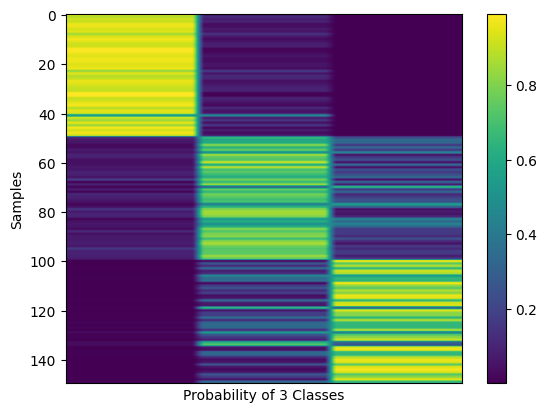

In [8]:
plot_probability_array(X,probability)

Here, is the output for the first sample:


In [9]:
probability[0,:]

array([9.57671606e-01, 4.22321095e-02, 9.62845517e-05])

We see it sums to one.


In [10]:
probability[0,:].sum()

1.0

We can apply the $argmax$ function.


In [11]:
np.argmax(probability[0,:])

0

We can apply the $argmax$ function to each sample.


In [12]:
# for each sample(raw), find the column(class) that has the highest probability
softmax_prediction=np.argmax(probability,axis=1)
softmax_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We can verify that sklearn does this under the hood by comparing it to the output of the method <code> predict  </code>.


In [13]:
yhat =lr.predict(X)
accuracy_score(yhat,softmax_prediction)

1.0

We can't use Softmax regression for SVMs, Let's explore two methods of Multi-class Classification that we can apply to SVM.


## SVM 


Sklean performs Multi-class Classification automatically, we can apply the method and calculate the accuracy. Train a SVM classifier with the `kernel` set to `linear`, `gamma` set to `0.5`, and the `probability` paramter set to `True`, then train the model using the `X` and `y` data.


In [14]:
model = SVC(kernel='linear', gamma=.5, probability=True)

model.fit(X,y)

SVC(gamma=0.5, kernel='linear', probability=True)

Find the `accuracy_score` on the training data.


In [15]:
yhat = model.predict(X)

accuracy_score(y,yhat)

0.96

We can plot the decision_boundary.


/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


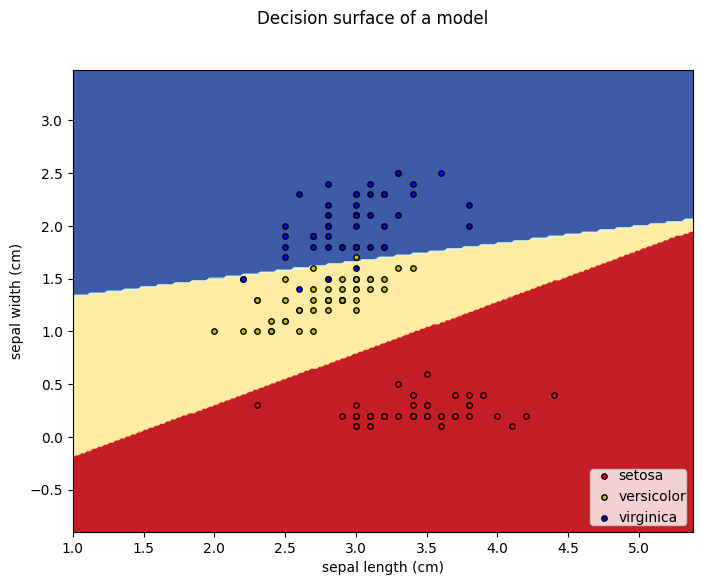

In [16]:
decision_boundary(X,y,model)

Let's implement One vs. All and One vs One:


## One vs. All (One-vs-Rest) 


For one-vs-all classification, if we have K classes, we use K two-class classifier models. The number of class labels present in the dataset is equal to the number of generated classifiers. First, we create an artificial class we will call this "dummy" class. For each classifier, we split the data into two classes. We take the class samples we would like to classify, the rest of the samples will be labelled as a dummy class. We repeat the process for each class. To make a  classification, we use the classifier with the highest probability, disregarding the dummy class.


### Train Each Classifier


Here, we train three classifiers and place them in the list <code>my_models</code>. For each class we take the class samples we would like to classify, and the rest will be labelled as a dummy class. We repeat the process for each class. For each classifier, we plot the decision regions. The class we are interested in is in red, and the dummy class is in blue. Similarly, the class samples are marked in blue, and the dummy samples are marked with a black x. 


/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


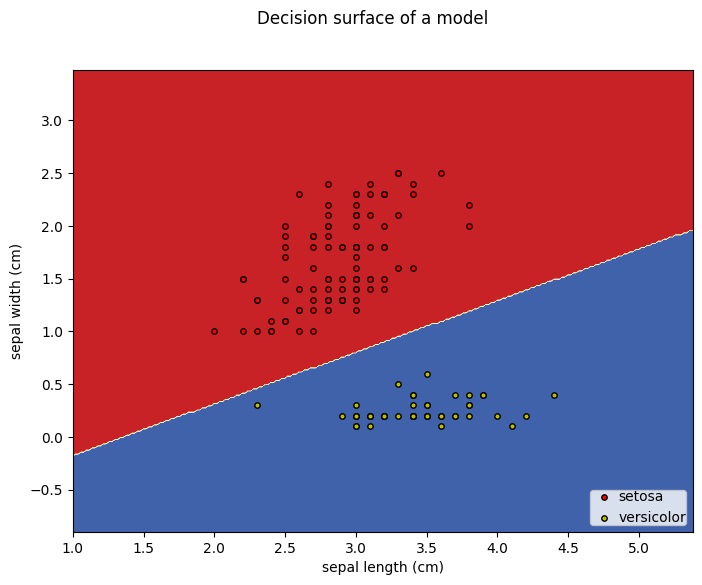

/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


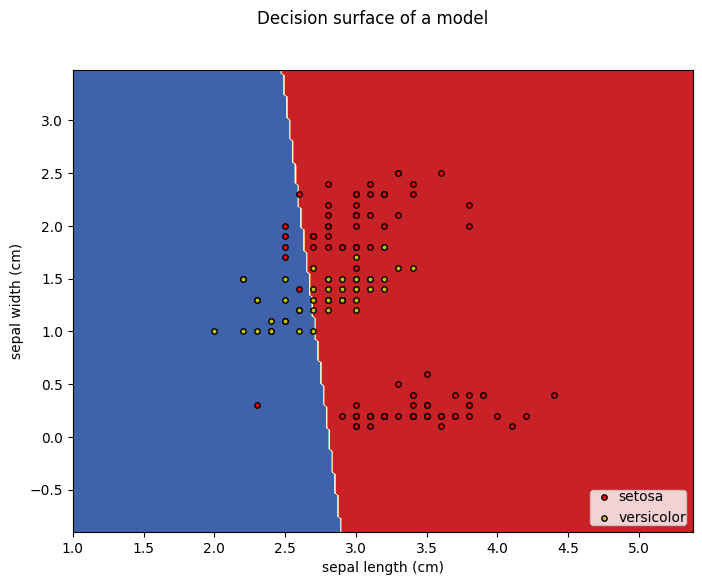

/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


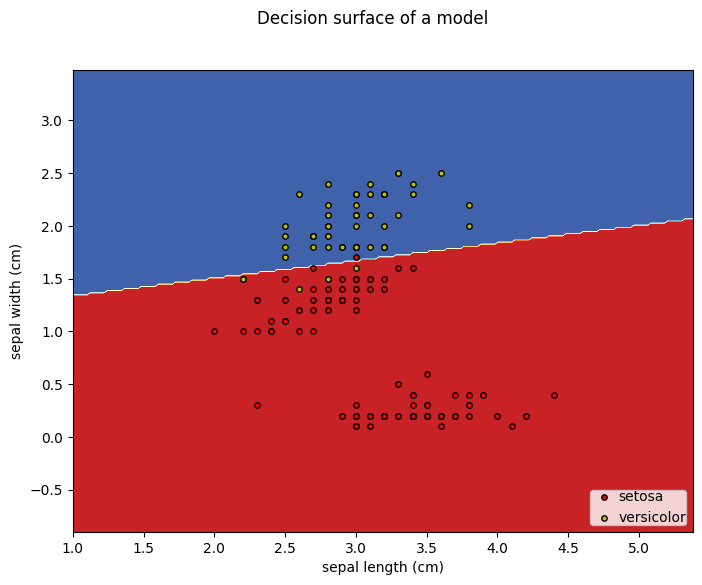

In [17]:
# initialize list to store classifiers
my_models = []

# iterate through each unique class label in y
for class_ in np.unique(y):
    # create binary labels: 1 for the current class, 0 for all other classes
    temp_y = (y == class_).astype(int)
    
    # initialize the SVM model with a linear kernel
    model = SVC(kernel='linear', probability=True)
    
    # train the model on the data
    model.fit(X, temp_y)
    
    # add the trained model to the list of classifiers
    my_models.append(model)
    
    decision_boundary(X, temp_y, model)

 For each sample we calculate the  probability of belonging to each class, not including the dummy class.


In [18]:
probability_array=np.zeros((X.shape[0],3))
for j,model in enumerate(my_models):

    real_class=np.where(np.array(model.classes_)!=3)[0]

    probability_array[:,j]=model.predict_proba(X)[:,real_class][:,0]

Here, is the probability of belonging to each class for the first sample.


In [19]:
probability_array[0,:]

array([0.00808158, 0.87451188, 0.99999783])

As each is the probability of belonging to the actual class and not the dummy class, it does not sum to one. 


In [20]:
probability_array[0,:].sum()

1.8825912902439967

We can plot the probability of belonging to the class. The row number is the sample number.


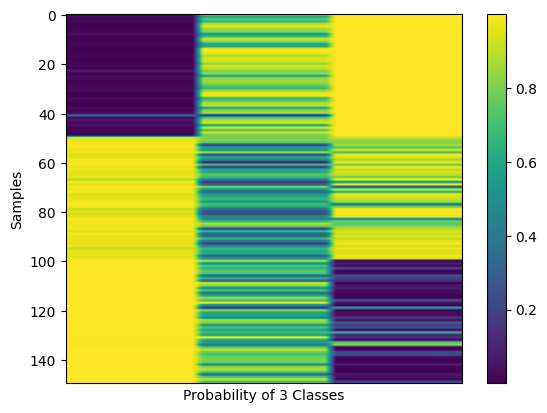

In [21]:
plot_probability_array(X,probability_array)

We can apply the $argmax$ function to each sample to find the class.


In [22]:
one_vs_all=np.argmax(probability_array,axis=1)
one_vs_all

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can calculate the accuracy. 


In [23]:
accuracy_score(y,one_vs_all)

0.0

We see the accuracy is less than the one obtained by sklearn, and this is because for SVM, sklearn uses one vs one; let's verify it by comparing the outputs. 


In [24]:
accuracy_score(one_vs_all,yhat)

0.0

We see that the outputs are different, now lets implement one vs one.


## One vs One 



In One-vs-One classification, we split up the data into each class, and then train a two-class classifier on each pair of classes. For example, if we have class 0,1,2, we would train one classifier on the samples that are class 0 and class 1, a second classifier on samples that are of class 0 and class 2, and a final classifier on samples of class 1 and class 2.

For $K$ classes, we have to train $K(K-1)/2$ classifiers. So, if $K=3$, we have $(3x2)/2=3 $classes.

To perform classification on a sample, we perform a majority vote and select the class with the most predictions. 


Here, we list each class.


In [25]:
classes_=set(np.unique(y))
classes_
   

{0, 1, 2}

Determine the number of classifiers:


In [26]:
K=len(classes_)
K*(K-1)/2

3.0

We then train a two-class classifier on each pair of classes. We plot the different training points for each of the two classes. 


class 0 vs class 1 


/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


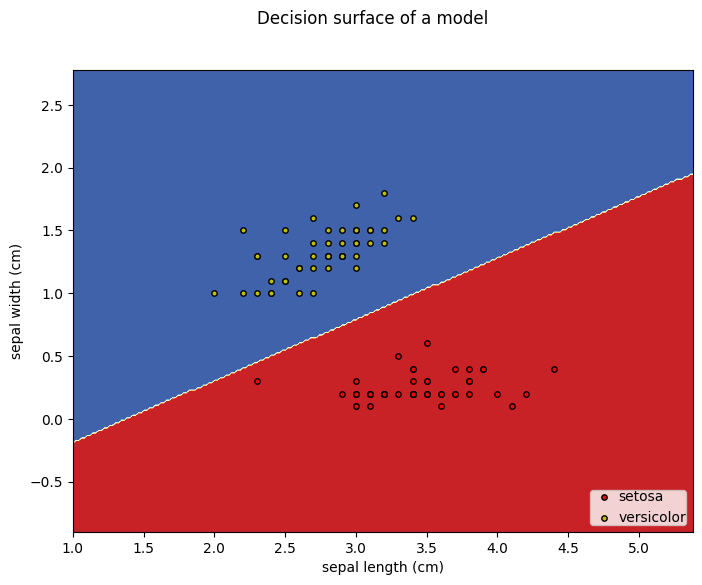

class 0 vs class 2 


/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


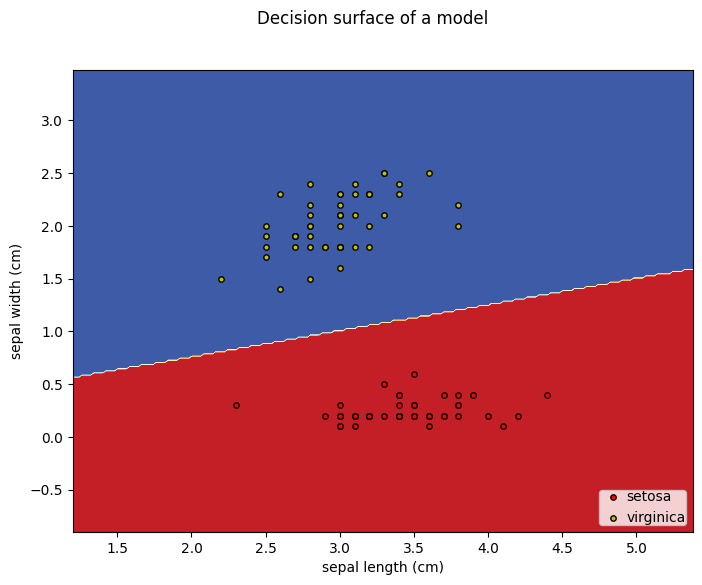

class 1 vs class 2 


/tmp/ipykernel_18/508858794.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],


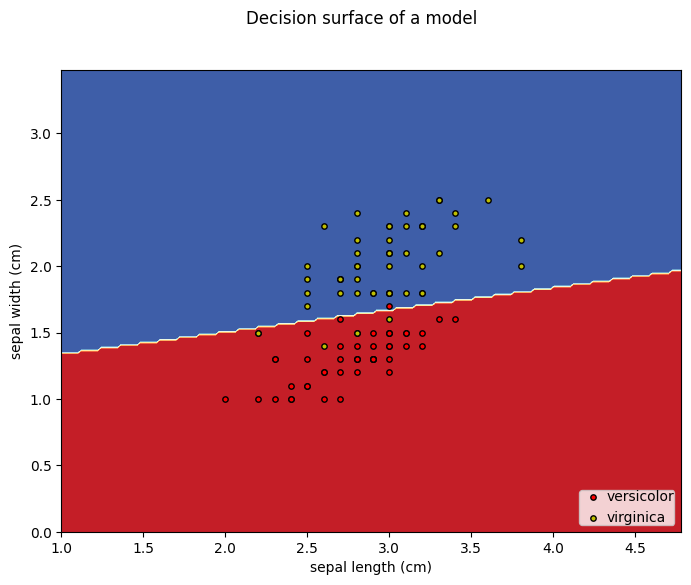

In [27]:
pairs=[]
left_overs=classes_.copy()
#list used for classifiers 
my_models=[]
#iterate through each class
for class_ in classes_:
    #remove class we have seen before 
    left_overs.remove(class_)
    #the second class in the pair
    for second_class in left_overs:
        pairs.append(str(class_)+' and '+str(second_class))
        print("class {} vs class {} ".format(class_,second_class) )
        temp_y=np.zeros(y.shape)
        #find classes in pair 
        select=np.logical_or(y==class_ , y==second_class)
        #train model 
        model=SVC(kernel='linear', gamma=.5, probability=True)  
        model.fit(X[select,:],y[select])
        my_models.append(model)
        #Plot decision boundary for each pair and corresponding Training samples. 
        decision_boundary (X[select,:],y[select],model)
   
        
    

In [28]:
pairs

['0 and 1', '0 and 2', '1 and 2']

As we can see, our data is left-skewed, containing more "5" star reviews. 


Here, we are plotting the distribution of text length.


In [29]:
pairs
majority_vote_array=np.zeros((X.shape[0],3))
majority_vote_dict={}
for j,(model,pair) in enumerate(zip(my_models,pairs)):

    majority_vote_dict[pair]=model.predict(X)
    majority_vote_array[:,j]=model.predict(X)

In the following table, each column is the output of a classifier for each pair of classes and the output is the prediction:


In [30]:
pd.DataFrame(majority_vote_dict).head(10)

,0 and 1,0 and 2,1 and 2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


To perform classification on a sample, we perform a majority vote, that is, select the class with the most predictions. We repeat the process for each sample. 


In [31]:
one_vs_one=np.array([np.bincount(sample.astype(int)).argmax() for sample  in majority_vote_array]) 
one_vs_one
    

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We calculate the accuracy:


In [32]:
accuracy_score(y,one_vs_one)

0.96

If we compare it to `sklearn`, it's the same! 


In [33]:
accuracy_score(yhat,one_vs_one)

1.0